In [1]:
import requests
import json
from bs4 import BeautifulSoup
from urllib.parse import urljoin, quote
from lxml import etree
import selenium
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
import time
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import datetime
#from selenium.webdriver.edge.options import Options
from selenium.webdriver.chrome.options import Options

import pandas as pd

In [2]:
def generate_urls(jugador, anio_inicio, mes_inicio, dia_inicio, anio_fin, mes_fin, dia_fin):
    # referencia https://news.google.com/search?q=nombre_jugador+de_futbol+after:YYYY-MM-DD+before:YYYY-MM-DD
    
    interval_tuples = []
    
    # se hacen intervalos de 1 semana
    while True:
        if anio_inicio == anio_fin and mes_inicio == mes_fin and dia_inicio >= dia_fin:
            break

        if anio_inicio == anio_fin and mes_inicio > mes_fin and dia_inicio:
            break

        if anio_inicio > anio_fin:
            break
        
        interval_tuples.append((anio_inicio, mes_inicio, dia_inicio))
        
        dia_inicio += 7
        
        if dia_inicio > 30:
            dia_inicio = 1
            mes_inicio += 1
        
        if mes_inicio > 12:
            mes_inicio = 1
            anio_inicio += 1

    print(interval_tuples)

    urls = []

    for interval in interval_tuples:
        anio, mes, dia = interval

        url = f"https://news.google.com/search?q={jugador.replace(' ', '%20')}+after:{anio}-{mes}-{dia}+before:{anio}-{mes}-{dia + 7}"
        urls.append(url)


    return urls


In [3]:
def get_news_links(url):
    edge_options = Options()
    edge_options.add_argument('--headless')
    edge_options.add_argument('--disable-gpu')
    edge_options.add_argument('--no-sandbox') 
    
    driver = webdriver.Edge(options=edge_options)
    driver.get(url)

    # Espera a que el botón de 'Accept all' esté presente y clicable
    wait = WebDriverWait(driver, 10)  # Espera hasta 10 segundos
    accept_button = wait.until(EC.element_to_be_clickable((By.XPATH, "//span[text()='Aceptar todo']")))

    # Hace clic en el elemento <span>
    accept_button.click()

    # Esperar a que la nueva página comience a cargarse o hacer algo en el medio si es necesario
    time.sleep(2)  # Pausa opcional para dar tiempo a la carga inicial de la página

    # Scroll hacia abajo hasta el final de la página
    last_height = driver.execute_script("return document.body.scrollHeight")

    while True:
            # Desplazarse hacia abajo
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            
            # Esperar a que se cargue la nueva sección
            time.sleep(2)  # Ajusta el tiempo según sea necesario para la página
            
            # Calcular la nueva altura de la página después del scroll
            new_height = driver.execute_script("return document.body.scrollHeight")
            
            # Si la altura no cambia, hemos llegado al final de la página
            if new_height == last_height:
                break
            
            last_height = new_height

    elements = driver.find_elements(By.CSS_SELECTOR, 'c-wiz[jsrenderer="ARwRbe"]')

    # Extraer los href de cada elemento si tienen un enlace dentro
    links = []
    for element in elements:
        # Buscar el enlace dentro del elemento
        link = element.find_element(By.TAG_NAME, 'a')
        href = link.get_attribute('href')
        if href:
            links.append(href)





    # Encontrar todos los elementos <time> con class="hvbAAd"
    time_elements = driver.find_elements(By.CSS_SELECTOR, 'time.hvbAAd')

    # Extraer el valor del atributo 'datetime' de cada <time>
    datetimes = []
    for element in time_elements:
        datetime_value = element.get_attribute('datetime')
        if datetime_value:
            datetimes.append(datetime_value)







    driver.quit()

    return links[1:], datetimes





In [4]:
def get_news_parragraphs(url):
    edge_options = Options()
    # edge_options.add_argument('--headless')

    driver = webdriver.Edge(options=edge_options)
    driver.get(url)


    try:
        # Espera a que el botón de 'Accept all' esté presente y clicable
        wait = WebDriverWait(driver, 10)  # Espera hasta 10 segundos
        #accept_button = wait.until(EC.element_to_be_clickable((By.XPATH, "//span[text()='Accept all']")))
        accept_button = wait.until(EC.element_to_be_clickable(
                    (By.XPATH, "//span[contains(text(), 'Accept all') or contains(text(), 'Aceptar todo')]")
                                                                ))
        
        # Hace clic en el elemento <span>
        accept_button.click()

        # Esperar a que la nueva página comience a cargarse o hacer algo en el medio si es necesario
        time.sleep(2)  # Pausa opcional para dar tiempo a la carga inicial de la página

        # Scroll hacia abajo hasta el final de la página
        last_height = driver.execute_script("return document.body.scrollHeight")
        
        movements = 0

        while True:
            # Desplazarse hacia abajo
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            
            # Esperar a que se cargue la nueva sección
            time.sleep(2)  # Ajusta el tiempo según sea necesario para la página
            
            # Calcular la nueva altura de la página después del scroll
            new_height = driver.execute_script("return document.body.scrollHeight")
            
            # Si la altura no cambia, hemos llegado al final de la página
            if new_height == last_height:
                break
            
            last_height = new_height

            movements += 1
            if movements == 4:
                break
        
        # Una vez que se ha llegado al final, obtener todos los párrafos <p>
        paragraphs = driver.find_elements(By.TAG_NAME, 'p')
        
        # Imprimir el texto de cada párrafo
        for paragraph in paragraphs:
            return paragraph.text

        
    except Exception as e:
        print(f"Error: {e}")
    finally:
        driver.quit()


In [ ]:
root_urls = generate_urls("Vinicius Jr", 2022, 1, 1, 2022, 6, 1)

news_links_list = []
news_datetimes_list = []

for url in root_urls:
    news_links, news_datetimes = get_news_links(url)
    news_links_list.extend(news_links)
    news_datetimes_list.extend(news_datetimes)

list_paragraphs = []

for news_links in news_links_list:
    paragraph = get_news_parragraphs(news_links)
    list_paragraphs.append(paragraph)

In [5]:
# leer el archivo csv yendo una carpeta atrás
df = pd.read_csv('raw/news_links.csv')

# crear una columna que marque si se ha scrapeado o no
df['scraped'] = 0

In [41]:
# get the first url
url = df['links'][11]

# get the paragraphs
paragraph = get_news_parragraphs(url)

paragraph

'No es una broma y todo tiene un estudio científico y de mercado por detrás. De acuerdo al CIES Football Observatory, medio especializado en valores y fluctuaciones de costos dentro del futbol, Vinicius Junior es el futbolista con mayor valor de mercado del mundo con una suma de 188 millones de dólares, pero lo increíble es que Kylian Mbappé es el número 50 con un monto de 81 millones.'

In [ ]:
url = df['links'][10]


driver = webdriver.Edge()


driver.get(url)





# Espera a que el botón de 'Accept all' esté presente y clicable
wait = WebDriverWait(driver, 10)  # Espera hasta 10 segundos
#accept_button = wait.until(EC.element_to_be_clickable((By.XPATH, "//span[text()='Accept all']")))
accept_button = wait.until(EC.element_to_be_clickable(
                    (By.XPATH, "//span[contains(text(), 'Accept all') or contains(text(), 'Aceptar todo')]")
                                                                ))

accept_button.click()

wait = WebDriverWait(driver, 10)

# consent_button = wait.until(EC.element_to_be_clickable(
#     (By.XPATH, "//button[@aria-label='Consentir']")
# ))

# consent_button.click()


accept_button_or_link = wait.until(EC.element_to_be_clickable(
    (By.XPATH, "//button[contains(translate(text(), 'ABCDEFGHIJKLMNOPQRSTUVWXYZ', 'abcdefghijklmnopqrstuvwxyz'), 'aceptar')] | //a[contains(translate(text(), 'ABCDEFGHIJKLMNOPQRSTUVWXYZ', 'abcdefghijklmnopqrstuvwxyz'), 'aceptar')] | //span[contains(translate(text(), 'ABCDEFGHIJKLMNOPQRSTUVWXYZ', 'abcdefghijklmnopqrstuvwxyz'), 'aceptar')]")
))

accept_button_or_link.click()


In [49]:
from googlenewsdecoder import new_decoderv1

def main():
    decoded_urls = []

    interval_time = 5 # default interval is 1 sec, if not specified

    for source_url in df['links'][30:]:

        try:
            decoded_url = new_decoderv1(source_url, interval=interval_time)
            if decoded_url.get("status"):
                print("Decoded URL:", decoded_url["decoded_url"])
                decoded_urls.append(decoded_url["decoded_url"])
            else:
                print("Error:", decoded_url["message"])
                return decoded_urls
        except Exception as e:
            print(f"Error occurred: {e}")
            return decoded_urls

    return decoded_urls


if __name__ == "__main__":
    urls = main()
    print(urls)

2024-10-02 16:42:21,926 - root - ERROR - get_decoding_params Request error: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://news.google.com/articles/CBMi0gFBVV95cUxOR2cydm54bjBZNUZoNVFkSXBIYlBBNjMzdW1ici1xMHB0ZjExakhJY25PLXpCSGlDYUw0NHVVZDl0NUY5aWJ0OFVzSEZDTVdBaU1HNVIzOG96TlR2ZUFBYUE0RnRlNy1ZSW1McHo5SFhFQS1CLUpGTkdzNmZCN29IV0JvS2NFT1p4NlJsQkhLZzA1Y1hSZk9IM3lRYTFGQjlFRXhHN1Ntc2dJWERYclBkNVRJYnhOYW1rR2xSa3ozWWNIaGk3WTB6aEhEeTI5UEowNGfSAdoBQVVfeXFMT0hud2JFTVdKeGhpOE0xbGNGVzN0Z2pCbFE1RFFuTFctUDJnM0JTWHk4cUxBaEw1TFdUS0ZNN3hFbURVa0pHZk12SUUzWHVrWHd0d3pUT3EtbmpTYmRrNE40dHgtQ3NGeHNGMUc1aE1sVHRqcm9qdVlqV0c5MkVtcWJXSWczVmkyby1sZEZEZlgwS3pkQUp4eS1JRXlnVE1tSlZBOXNQXy1wNGI3MWVOcmJjQVBUSERHa1RuYXBWZUhNVDkteXE5bmtpMEw0NVFicDZMOEQ5VEg2eFE&q=EgSKBOsAGMy39bcGIjCvtCYkHs6tGluKXqvcCdaAkOExxUgr3YbCKq8jduMGDW7dTwZ47FkUyJ53QHzCMT0yAXJaAUM


Error: Request error in get_decoding_params: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://news.google.com/articles/CBMi0gFBVV95cUxOR2cydm54bjBZNUZoNVFkSXBIYlBBNjMzdW1ici1xMHB0ZjExakhJY25PLXpCSGlDYUw0NHVVZDl0NUY5aWJ0OFVzSEZDTVdBaU1HNVIzOG96TlR2ZUFBYUE0RnRlNy1ZSW1McHo5SFhFQS1CLUpGTkdzNmZCN29IV0JvS2NFT1p4NlJsQkhLZzA1Y1hSZk9IM3lRYTFGQjlFRXhHN1Ntc2dJWERYclBkNVRJYnhOYW1rR2xSa3ozWWNIaGk3WTB6aEhEeTI5UEowNGfSAdoBQVVfeXFMT0hud2JFTVdKeGhpOE0xbGNGVzN0Z2pCbFE1RFFuTFctUDJnM0JTWHk4cUxBaEw1TFdUS0ZNN3hFbURVa0pHZk12SUUzWHVrWHd0d3pUT3EtbmpTYmRrNE40dHgtQ3NGeHNGMUc1aE1sVHRqcm9qdVlqV0c5MkVtcWJXSWczVmkyby1sZEZEZlgwS3pkQUp4eS1JRXlnVE1tSlZBOXNQXy1wNGI3MWVOcmJjQVBUSERHa1RuYXBWZUhNVDkteXE5bmtpMEw0NVFicDZMOEQ5VEg2eFE&q=EgSKBOsAGMy39bcGIjCvtCYkHs6tGluKXqvcCdaAkOExxUgr3YbCKq8jduMGDW7dTwZ47FkUyJ53QHzCMT0yAXJaAUM
[]


# Vamos a hacerlo mas sencillo 
Google ya que no nos deja recoger la noticia entera, ya que detecta que estamos usando un bot.
Vamos a recoger el resumen de las noticias.

In [50]:
from gnews import GNews

In [126]:
def create_dates_intervals(start_year, start_month, start_day, end_year, end_month, end_day):
    dates = []
    while True:
        if start_year == end_year and start_month == end_month and start_day > end_day:
            break

        if start_year == end_year and start_month > end_month:
            break

        if start_year > end_year:
            break

        dates.append((start_year, start_month, start_day))

        start_day += 7

        if start_day > 30:
            start_day = 1
            start_month += 1

        if start_month > 12:
            start_month = 1
            start_year += 1

    return dates


def convert_dates(date_str):
    months_dic = {
    'Jan': 1,
    'Feb': 2,
    'Mar': 3,
    'Apr': 4,
    'May': 5,
    'Jun': 6,
    'Jul': 7,
    'Aug': 8,
    'Sep': 9,
    'Oct': 10,
    'Nov': 11,
    'Dec': 12
}


    day = int(date_str[5:7])
    month = months_dic[date_str[8:11]]
    year = int(date_str[12:16])

    return day, month, year

In [127]:
dates = create_dates_intervals(2023, 8, 1, 2024, 5, 26)
print(dates)


l_news = []

google_news = GNews()


for date in range(len(dates)-1):

    google_news.max_results = 15

    print(dates[date], dates[date + 1])
    try:
        google_news.start_date = dates[date]
    except:
        google_news.start_date = (dates[date][0], dates[date][1], dates[date][2] - 1)
    try:
        google_news.end_date = dates[date + 1]
    except:
        google_news.end_date = (dates[date + 1][0], dates[date + 1][1], dates[date + 1][2] - 1)
    
    news = google_news.get_news('Vinicius Jr')

    l_news.extend([(new['description'], convert_dates(new['published date'])) for new in news])



[(2023, 8, 1), (2023, 8, 8), (2023, 8, 15), (2023, 8, 22), (2023, 8, 29), (2023, 9, 1), (2023, 9, 8), (2023, 9, 15), (2023, 9, 22), (2023, 9, 29), (2023, 10, 1), (2023, 10, 8), (2023, 10, 15), (2023, 10, 22), (2023, 10, 29), (2023, 11, 1), (2023, 11, 8), (2023, 11, 15), (2023, 11, 22), (2023, 11, 29), (2023, 12, 1), (2023, 12, 8), (2023, 12, 15), (2023, 12, 22), (2023, 12, 29), (2024, 1, 1), (2024, 1, 8), (2024, 1, 15), (2024, 1, 22), (2024, 1, 29), (2024, 2, 1), (2024, 2, 8), (2024, 2, 15), (2024, 2, 22), (2024, 2, 29), (2024, 3, 1), (2024, 3, 8), (2024, 3, 15), (2024, 3, 22), (2024, 3, 29), (2024, 4, 1), (2024, 4, 8), (2024, 4, 15), (2024, 4, 22), (2024, 4, 29), (2024, 5, 1), (2024, 5, 8), (2024, 5, 15), (2024, 5, 22)]
(2023, 8, 1) (2023, 8, 8)
(2023, 8, 8) (2023, 8, 15)


c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\gnews\gnews.py:130: UserWarning: The start and end dates should be at least 1 day apart, or GNews will return no results
  warnings.warn("The start and end dates should be at least 1 day apart, or GNews will return no results")


(2023, 8, 15) (2023, 8, 22)
(2023, 8, 22) (2023, 8, 29)
(2023, 8, 29) (2023, 9, 1)
(2023, 9, 1) (2023, 9, 8)
(2023, 9, 8) (2023, 9, 15)
(2023, 9, 15) (2023, 9, 22)
(2023, 9, 22) (2023, 9, 29)
(2023, 9, 29) (2023, 10, 1)
(2023, 10, 1) (2023, 10, 8)
(2023, 10, 8) (2023, 10, 15)
(2023, 10, 15) (2023, 10, 22)
(2023, 10, 22) (2023, 10, 29)
(2023, 10, 29) (2023, 11, 1)
(2023, 11, 1) (2023, 11, 8)
(2023, 11, 8) (2023, 11, 15)
(2023, 11, 15) (2023, 11, 22)
(2023, 11, 22) (2023, 11, 29)
(2023, 11, 29) (2023, 12, 1)
(2023, 12, 1) (2023, 12, 8)
(2023, 12, 8) (2023, 12, 15)
(2023, 12, 15) (2023, 12, 22)
(2023, 12, 22) (2023, 12, 29)
(2023, 12, 29) (2024, 1, 1)
(2024, 1, 1) (2024, 1, 8)
(2024, 1, 8) (2024, 1, 15)
(2024, 1, 15) (2024, 1, 22)
(2024, 1, 22) (2024, 1, 29)
(2024, 1, 29) (2024, 2, 1)
(2024, 2, 1) (2024, 2, 8)
(2024, 2, 8) (2024, 2, 15)
(2024, 2, 15) (2024, 2, 22)
(2024, 2, 22) (2024, 2, 29)
(2024, 2, 29) (2024, 3, 1)
(2024, 3, 1) (2024, 3, 8)
(2024, 3, 8) (2024, 3, 15)
(2024, 3, 15) (202

In [129]:
print(len(l_news))
l_news[:3]

700


[('No Kylian Mbappe? Real Madrid still have a star in attack in Vinicius Jr - The Athletic  The New York Times',
  (3, 8, 2023)),
 ('Analysis: Can Vinicius Jr position change ease Kylian Mbappe into Real Madrid?  Football Espana',
  (4, 8, 2023)),
 ('Brave move! Vinicius Jr asked for Cristiano Ronaldo’s old No.7 shirt at Real Madrid  Goal.com',
  (4, 8, 2023))]

# ESTA PARTE ES REFERENTE AL "PROCESADO"

In [75]:
from transformers import pipeline

c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\utils\generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [76]:
# Cargar pipeline de análisis de sentimiento
sentiment_analysis = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
c:\Users\santi\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\santi\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activ

In [131]:
list_to_df = []

for desc, date in l_news:
    list_to_df.append([desc, date, sentiment_analysis(desc)[0]['label']])

df = pd.DataFrame(list_to_df, columns=['description', 'date', 'sentiment'])


In [132]:
df

,description,date,sentiment
0,No Kylian Mbappe? Real Madrid still have a sta...,"(3, 8, 2023)",NEGATIVE
1,Analysis: Can Vinicius Jr position change ease...,"(4, 8, 2023)",NEGATIVE
2,Brave move! Vinicius Jr asked for Cristiano Ro...,"(4, 8, 2023)",POSITIVE
3,Real Madrid defender Antonio Rüdiger opens up ...,"(8, 8, 2023)",POSITIVE
4,"Real Madrid vs Juventus score, result, highlig...","(2, 8, 2023)",POSITIVE
...,...,...,...
695,"""He's the best"" - Real Madrid defender chooses...","(16, 5, 2024)",POSITIVE
696,"LaLiga: Vinicius Junior, Jude Bellingham steal...","(15, 5, 2024)",POSITIVE
697,La Liga: Vinicius double helps Real to 5-0 win...,"(15, 5, 2024)",POSITIVE
698,FIFA urge all national federations to make rac...,"(16, 5, 2024)",NEGATIVE


<Axes: xlabel='month'>

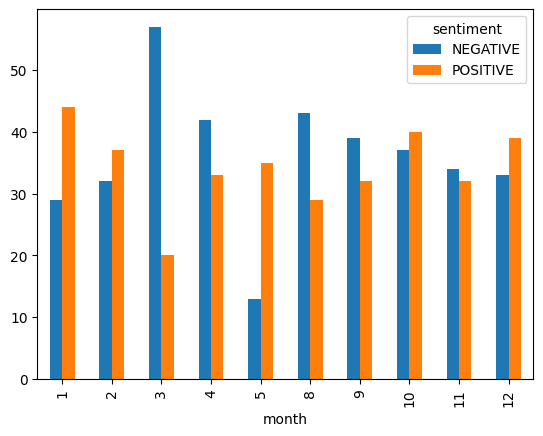

In [139]:
# see how many positive and negative news are there per month
df['month'] = df['date'].apply(lambda x: x[1])


# plot it
df.groupby(['month', 'sentiment']).size().unstack().plot(kind='bar', stacked=False)


In [141]:
# quitamos la columna meses
df.drop(['month'], axis=1, inplace=True)

# guardamos el df como csv en la carpeta raw

df.to_csv('raw/vinicius_news.csv', index=False)